## This final project focuses on leveraging the techniques and concepts you've learned throughout this course.
- You will apply image processing, feature extraction, and pattern recognition methods to solve real-world challenges. Specifically, you will implement and fine-tune state-of-the-art algorithms like Convolutional Neural Networks (CNNs), object detection, image segmentation, or even feature matching.

![image-2.png](attachment:image-2.png)

we'll build a CNN using Keras to use it classifying thousands of pictures in six different categories

Data link : https://www.kaggle.com/puneet6060/intel-image-classification

#Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob as gb
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from tqdm import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from google.colab import drive
from sklearn.model_selection import train_test_split



#define the path ( to swtich it between jupyter notebook & kaggle kernel)

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
os.getcwd()
train_path = r'/content/drive/My Drive/Colab Notebooks/computervision_project/seg_train/seg_train'
test_path = r'/content/drive/My Drive/Colab Notebooks/computervision_project/seg_test/seg_test'
pred_path = r'/content/drive/My Drive/Colab Notebooks/computervision_project/seg_pred/seg_pred'

#Checking Images
now we need to heck the images sizes , to know ow they looks like

since we have 6 categories , we first need to create a dictionary with their names & indices , also create a function to get the code back

In [4]:
code = {'buildings':0 ,'forest':1,'glacier':2,'mountain':3,'sea':4,'street':5}

def get_code(n):
    for x,y in code.items():
        if n==y:
            return x
get_code(3)

'mountain'

ok , since almost all of pictures are 150,150,3 , we can feel comfort in using all pictures in our model , after resizing it in a specific amount

#Reading Images
now it's time to read all images & convert it into arrays

first we'll create a variable s , which refer to size , so we can change it easily

let's use now size = 100 , so it will be suitable amount to contain accuracy without losing so much time in training

In [5]:
# resized_shape=100

# def load_images(image_path, code, resize_shape=(150, 150), is_subfolder=True):
#     """
#     Loads and resizes images from the specified path.

#     Parameters:
#     - image_path: Path where images are stored.
#     - code: A dictionary mapping folder names to labels.
#     - resize_shape: Tuple specifying the new size for resizing images (default is (100, 100)).
#     - is_subfolder: Boolean indicating if images are in subfolders (True for train/test, False for prediction).

#     Returns:
#     - x_data: A NumPy array of resized images.
#     - y_data: Corresponding labels (if applicable, else returns None for prediction data).
#     """
#     x_data = []
#     y_data = []

#     if is_subfolder:
#         for folder in os.listdir(image_path):
#             folder_path = os.path.join(image_path, folder)
#             images = gb.glob(pathname=os.path.join(folder_path, '*.jpg'))
#             for img_path in images:
#                 image = plt.imread(img_path)  # Alternatively, you can use cv2.imread for BGR images###@@@@ plt.imread
#                 image_resized = cv2.resize(image, resize_shape)
#                 x_data.append(image_resized)
#                 y_data.append(code[folder])  # Append the folder's label
#     else:
#         images = gb.glob(pathname=os.path.join(image_path, '*.jpg'))
#         for img_path in images:
#             image = cv2.imread(img_path)
#             image_resized = cv2.resize(image, resize_shape)
#             x_data.append(image_resized)
#         y_data = None  # No labels for prediction data

#     return np.array(x_data), np.array(y_data)


# # Usage for train data
# x_train, y_train = load_images(train_path, code, resize_shape=(resized_shape, resized_shape), is_subfolder=True)

# # Usage for test data
# x_test, y_test = load_images(test_path, code, resize_shape=(resized_shape, resized_shape), is_subfolder=True)

# # Usage for prediction data (no labels)
# x_pred, _ = load_images(pred_path, code=None, resize_shape=(resized_shape, resized_shape), is_subfolder=False)

# print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
# print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
# print(f"x_pred shape: {x_pred.shape}")

# import numpy as np

# # Save each array to .npy files on your drive
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_train.npy', x_train)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_train.npy', y_train)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_test.npy', x_test)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_test.npy', y_test)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_pred.npy', x_pred)


In [6]:
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_train.npy', x_train)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_train.npy', y_train)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_test.npy', x_test)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_test.npy', y_test)
# np.save(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_pred.npy', x_pred)

In [7]:
resized_shape=100

x_train = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_train.npy')
y_train = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_train.npy')
x_test = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_test.npy')
y_test = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/y_test.npy')
x_pred = np.load(r'/content/drive/My Drive/Colab Notebooks/computervision_project/x_pred.npy')


In [8]:

# Set a seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

# Generate the same random permutation index for both x_train and y_train
permutation = np.random.permutation(len(x_train))
x_train = x_train[permutation]
y_train = y_train[permutation]

# Do the same for x_test
permutation_test = np.random.permutation(len(x_test))
x_test = x_test[permutation_test]
y_test = y_test[permutation_test]


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

x_train=np.array(x_train)
x_test=np.array(x_test)

y_train=np.array(y_train)
y_test=np.array(y_test)

x_pred=np.array(x_pred)

print(x_train.shape)
print(x_test.shape)

print(y_train.shape)
print(y_test.shape)

print(x_pred.shape)


num_classes = 6



(14074, 100, 100, 3)
(3000, 100, 100, 3)
(14074,)
(3000,)
(7311, 100, 100, 3)


In [11]:
x_train=x_train/255.0
x_test=x_test/255.0
x_pred=x_pred/255.0




In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

num_classes = 6
x_train = np.array(x_train)[:]
x_test = np.array(x_test)[:]
y_train = to_categorical(np.array(y_train)[:], num_classes=num_classes)
y_test = to_categorical(np.array(y_test)[:], num_classes=num_classes)

# x_train = np.array(x_train)
# x_test = np.array(x_test)
# y_train = to_categorical(np.array(y_train), num_classes=num_classes)
# y_test = to_categorical(np.array(y_test), num_classes=num_classes)

train_datagen = ImageDataGenerator(
      # rescale=1.0/255,
      # rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest'
)

#val_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator()

# Create generators
train_generator = train_datagen.flow(
    x_train[:5000],
    y_train[:5000],
    batch_size=128
)

val_generator = val_datagen.flow(
    x_train[5001:6000],
    y_train[5001:6000],
    batch_size=128
)

In [25]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [26]:
def vgg16_architecture():
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.80)(x)

    output = Dense(num_classes, activation='softmax')(x)

    VGG16_model = Model(inputs=base_model.input, outputs=output)

    VGG16_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG16_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG16_model

In [27]:
def vgg19_architecture():
    from keras.applications import VGG19
    base_model = VGG19(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    from keras.layers import BatchNormalization, Dropout

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.80)(x)

    output = Dense(6, activation='softmax')(x)

    VGG19_model = Model(inputs=base_model.input, outputs=output)

    VGG19_model.summary()

    optimizer = Adam(learning_rate=0.001)
    VGG19_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return VGG19_model

In [28]:
def resnet152v2_architecture():
    from keras.applications import ResNet152V2
    base_model = ResNet152V2(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
    from keras.layers import BatchNormalization, Dropout

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.80)(x)

    output = Dense(6, activation='softmax')(x)

    ResNet152V2_model = Model(inputs=base_model.input, outputs=output)

    ResNet152V2_model.summary()

    optimizer = Adam(learning_rate=0.001)
    ResNet152V2_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return ResNet152V2_model

In [29]:
def inception_v3_architecture():
    from keras.applications import InceptionV3

    from keras.layers import BatchNormalization, Dropout

    base_model = InceptionV3(include_top=False, weights="imagenet", input_shape=(100, 100, 3))

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.80)(x)

    output = Dense(6, activation='softmax')(x)

    InceptionV3_model = Model(inputs=base_model.input, outputs=output)

    InceptionV3_model.summary()

    optimizer = Adam(learning_rate=0.001)
    InceptionV3_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return InceptionV3_model

In [30]:
def evaluate_model(model, x_test, yy_test):
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    return loss, accuracy

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    cr = classification_report(y_true, y_pred, target_names=[f'class_{i}' for i in range(3)])
    print("Classification Report:")
    print(cr)

    return cm, cr




In [31]:
models = {
    #  "VGG16": vgg16_architecture,
    #  "VGG19": vgg19_architecture,
     "ResNet152V2": resnet152v2_architecture,
    #  "InceptionV3": inception_v3_architecture
 }

for model_name, model_func in models.items():
    print(f"Training {model_name}...")
    model = model_func()
    model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=15  # Adjust epochs as needed
    )
    print(f"Evaluating {model_name}...")
    loss, accuracy = evaluate_model(model, x_test, y_test)
    print(f"{model_name} evaluation complete.")
    print(f"Accuracy: {accuracy}\n")
        # Define the path where you want to save the model
    model_save_path = f'/content/drive/My Drive/Colab Notebooks/computervision_project/model_weights/best_model_{model_name}.keras'

    # Save the model to the specified path
    model.save(model_save_path)
    print("_______________________________________________________________________")

Training ResNet152V2...
234545216/234545216 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 106, 106, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 50, 50, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 52, 52, 64)           0         ['conv1_conv[0][0]']          
   

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

def generate_confusion_matrix_and_metrics(model, x_test, y_test):
    # Generate predictions
    y_pred = model.predict(x_test)

    # Check the shape of y_pred and y_test
    print(f"y_pred shape: {y_pred.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Handle binary and multi-class predictions
    if len(y_pred.shape) == 1:  # Binary classification
        y_pred_classes = (y_pred > 0.5).astype(int)
    else:  # Multi-class classification
        y_pred_classes = np.argmax(y_pred, axis=1)

    # Check the shape after prediction conversion
    print(f"y_pred_classes shape: {y_pred_classes.shape}")

    # Check true labels
    if len(y_test.shape) == 1:  # if y_test is one-dimensional
        y_true = y_test.astype(int)  # assuming y_test contains class indices directly
    else:
        y_true = np.argmax(y_test, axis=1)  # True classes in one-hot encoded format

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification report
    labels = np.unique(y_true)
    target_names = [f'class_{label}' for label in labels]
    report = classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names)
    print("Classification Report:")
    print(report)

    # Precision, Recall, F1-score
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, labels=labels, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1_score:.4f}')

    return cm, report, precision, recall, f1_score


generate_confusion_matrix_and_metrics for ResNet152V2...
94/94 [==============================] - 39s 357ms/step
y_pred shape: (3000, 6)
y_test shape: (3000, 6)
y_pred_classes shape: (3000,)


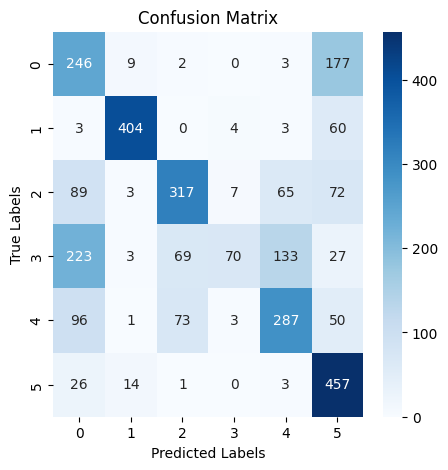

Classification Report:
              precision    recall  f1-score   support

     class_0       0.36      0.56      0.44       437
     class_1       0.93      0.85      0.89       474
     class_2       0.69      0.57      0.62       553
     class_3       0.83      0.13      0.23       525
     class_4       0.58      0.56      0.57       510
     class_5       0.54      0.91      0.68       501

    accuracy                           0.59      3000
   macro avg       0.66      0.60      0.57      3000
weighted avg       0.66      0.59      0.57      3000

Precision: 0.6612
Recall: 0.5937
F1-score: 0.5707
_______________________________________________________________________


In [33]:
for model_name, model_func in models.items():
  print(f"generate_confusion_matrix_and_metrics for {model_name}...")
  generate_confusion_matrix_and_metrics(model, x_test, y_test)
  print("_______________________________________________________________________")

## In the code above, I have provided you with a written code, but it contains errors. Each of you must trace the errors and improve the accuracy for each model, recording the changes in the table below. Then, answer the following questions.

| Network          | Accuracy | Recall | Precision | F1-Score |
|------------------|----------|--------|-----------|----------|
| Your CNN model   |   0.81   |0.8073  |  0.8249   |  0.7980  |
| VGG16            |   0.85   | 0.8487 |  0.8554   |  0.8467  |
| VGG19            |  0.67    | 0.6743 |  0.7393   |  0.6370  |
| Inception_V3     | 0.87     | 0.8693 |0.8719     | 0.8692   |
| RasNet152V2      |0.59      | 0.5937 | 0.6612    | 0.5707   |


models are saved in this link:
https://drive.google.com/drive/folders/1MBBe5P_spSX1CMMKjtXZsW4eaa0qP1pL






# Experimental Results